# Modelo final ponderado

Para generar un sólo recomendador, se propone ponderar los 3 sistemas generados en uno sólo. Para esto, el modelo final genera recomendaciones con cada uno de los 3 tipos de modelos y luego mezcla estas recomendaciones eligiendo aleatoreamente según ciertas probabilidades asociadas a cada modelo. 

Adicionalmente, se crea la función "Feedback" que actualiza las probabilidades asociadas a cada recomendador para ajustarse más a las preferencias del usuario. De esta manera, si al usuario le gustan más las recomendaciones de un cierto modelo de recomendación, aumentará la probabilidad de que se elijan recomendaciones de ese modelo.

In [1]:
import pandas as pd
import numpy as np

from recommenders import validar_lista, validar_recomendador, Recommender1, Recommender2, Recommender3, RecommenderMean

Se carga y pre procesa los datos

In [2]:
playlists_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_playlists_validation.csv')
tracks_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_tracks_validation.csv')
artist_info = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/artist/2000_artist_sample.csv.gz')

# Se genera set de pids (playlist id) únicos
pids = list(set(playlists_val["pid"]))

cols=tracks_val.columns
tracks_val.columns=[col[15:] if col[:15]=="audio_features." else col for col in cols]
tracks_val = tracks_val.drop(columns=["Unnamed: 0"])

var_names=["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
tracks_info = playlists_val.drop_duplicates(subset=["track_uri"]).set_index("track_uri")[["track_name", "artist_name"]].loc[tracks_val["uri"]]

Se crean las 3 instancias para cada modelo

In [3]:
# Recommender1
avg_features_by_pid = \
        playlists_val \
            .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
            [['pid','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
            .groupby('pid') \
            .mean() \
            .reset_index()

features_by_pid_plus_artist = \
    playlists_val \
    .merge(tracks_val, left_on='track_uri', right_on='uri', how='inner') \
    [['pid','artist_uri', 'track_uri', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] \
    .drop_duplicates(subset=['artist_uri']) \
    .merge(artist_info[['artists.uri', 'artists.popularity']], left_on='artist_uri', right_on='artists.uri', how='left') \
    .drop(['artists.uri'], axis=1)

recomendador_1 = Recommender1(avg_features_by_pid)
recomendador_1.fit(avg_features_by_pid.iloc[:, 1:].to_numpy(), 
                   avg_features_by_pid.iloc[:, 0].to_numpy(),
                   features_by_pid_plus_artist)

# Recommender2
recomendador_2=Recommender2(var_names)
recomendador_2.train(tracks_val, playlists_val)

# Recommender3
recomendador_3 = Recommender3(var_names)
recomendador_3.load_data(tracks_val)

0
10
20
30
40


Cargamos una lista de prueba para ver las recomendaciones del modelo ponderado

In [4]:
test=pd.read_csv("../data/10_canciones_features_azar.csv")

Creamos el modelo ponderado dandoles los 3 modelos recomendadores creados anteriormente. Utilizaremos los porcentajes de eficiencia obtenidos en validación para obtener los pesos iniciales asociados a los modelos. De esta manera, el recomendador ponderado inicialmente tendrá más probabilidades de elegir recomendaciones de los modelos que mayor puntaje tuvieron en validación. Con el paso del tiempo, estos puntajes podrían cambiar si el usuario tiene más preferencia por las recomendaciones de un mismo recomendador.

In [12]:
np.random.seed(1991)
rec_promedio=RecommenderMean([recomendador_1, recomendador_2, recomendador_3], [2.1, 15.5, 13.6])
tracks_info.loc[rec_promedio.recommend_list(test, number=20)]

,track_name,artist_name
track_uri,,
spotify:track:0J6mQxEZnlRt9ymzFntA6z,Livin' On A Prayer,Bon Jovi
spotify:track:5CjwXdq5Z73Va0XCPFG5Aq,The Good Life,Weezer
spotify:track:29BmtsadNYhlWDKpqyAnVr,Why God Made Love Songs - Single Version,Joel Crouse
spotify:track:7pEjMcUwSQ8E6dzi3AiWHu,Hard to Be Cool,Joe Nichols
spotify:track:0LN0ASTtcGIbNTnjSHG6eO,Pour Some Sugar On Me (2012),Def Leppard
spotify:track:23B2mTKFIHLE9qoLGMMtYW,Born Again Tomorrow,Bon Jovi
spotify:track:3EY7mzKglmxJw21WGUYPLB,Sister Jack,Spoon
spotify:track:756CJtQRFSxEx9jV4P9hpA,I Believe In A Thing Called Love,The Darkness
spotify:track:71DDK14XVxkXLmG3AVi1BP,Storm Warning,Hunter Hayes


# Validación

Realizamos la validación del recomendador ponderado con el mismo método que para cada recomendador anteriormente. Vemos que, en promedio, la eficiencia del recomendador ponderado es un punto intermedio entre las eficiencias de cada recomendador por separado.

Generando recomendaciones Playlist 5 de 50. % Recomendaciones correctas: 62.84
Generando recomendaciones Playlist 10 de 50. % Recomendaciones correctas: 7.22
Generando recomendaciones Playlist 15 de 50. % Recomendaciones correctas: 15.31
Generando recomendaciones Playlist 20 de 50. % Recomendaciones correctas: 14.42
Generando recomendaciones Playlist 25 de 50. % Recomendaciones correctas: 4.76
Generando recomendaciones Playlist 30 de 50. % Recomendaciones correctas: 4.21
Generando recomendaciones Playlist 35 de 50. % Recomendaciones correctas: 3.95
Generando recomendaciones Playlist 40 de 50. % Recomendaciones correctas: 12.11
Generando recomendaciones Playlist 45 de 50. % Recomendaciones correctas: 2.59
Generando recomendaciones Playlist 50 de 50. % Recomendaciones correctas: 14.08
Eficiencia recomendador 3: 12.37105471349387 %


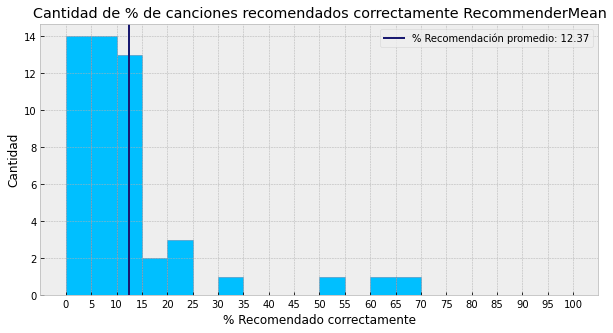

In [6]:
np.random.seed(1991)
eficiencia_pond = validar_recomendador(playlists_val, tracks_val, pids, rec_promedio)
print("Eficiencia recomendador 3:", eficiencia_pond,"%")

# Feedback

Por la validación del recomendador ponderado parecería a simple vista que sería preferible elegir el recomendador 2 o 3 en vez del ponderado. Sin embargo, una ventaja de tener el ponderado es que el mismo usuario puede elegir el algoritmo que más desee y así tener un recomendador personalizado a sus preferencias. Alta eficiencia de predicción de canciones de la misma playlist no implica necesariamente que el modelo da mejores recomendaciones, ya que algunos usuarios pueden preferir canciones según otros atributos.

A continuación mostraremos como funciona el algoritmo de feedback del recomendador promedio. Supongamos que al usuario le gustaron las siguientes canciones:
- The Good Life - Weezer
- Sister Jack - Spoon
- Don't It - Billy Currington

Las 3 canciones pertenecen al recomendador 2. Realizamos el feedback y observamos como cambian las probabilidades de elegir canciones y y también las recomendaciones en sí. Primero vemos los pesos de cada recomendador antes del feedback.

In [9]:
[print("Recomendador", i,"probabilidad:", prob) for i, prob in enumerate(rec_promedio.probs)]; pass

Recomendador 0 probabilidad: 0.0673076923076923
Recomendador 1 probabilidad: 0.49679487179487175
Recomendador 2 probabilidad: 0.43589743589743585


Luego realizamos el feedback utilizando los **track_uri** de las canciones seleccionadas.

In [13]:
rec_promedio.feedback("spotify:track:5CjwXdq5Z73Va0XCPFG5Aq" ,lr=0.05)
rec_promedio.feedback("spotify:track:3EY7mzKglmxJw21WGUYPLB" ,lr=0.05)
rec_promedio.feedback("spotify:track:4iLPK8QnOvqm0Azbsk2GDn" ,lr=0.05)

Thanks for your feedback!
Thanks for your feedback!
Thanks for your feedback!


El factor $lr$ corresponde a que tan relevante es el feedback dado. EL feedback puede ser simplemente escuchar la recomendación, escucharla completa, ponerle "me gusta", etc. Cada una de estas acciones tiene una relevancia distinta en determinar si al usuario le gustó la canción. Vemos como quedaron las probabilidades de cada lista.

In [14]:
[print("Recomendador", i,"probabilidad:", prob) for i, prob in enumerate(rec_promedio.probs)]; pass

Recomendador 0 probabilidad: 0.05770793269230768
Recomendador 1 probabilidad: 0.5685645032051282
Recomendador 2 probabilidad: 0.373727564102564


Se observa un aumento en la probabilidad del recomendador 2. Exploramos si hubo cambios en las recomendaciones.

In [15]:
np.random.seed(1991)
tracks_info.loc[rec_promedio.recommend_list(test, number=20)]

,track_name,artist_name
track_uri,,
spotify:track:0J6mQxEZnlRt9ymzFntA6z,Livin' On A Prayer,Bon Jovi
spotify:track:5CjwXdq5Z73Va0XCPFG5Aq,The Good Life,Weezer
spotify:track:29BmtsadNYhlWDKpqyAnVr,Why God Made Love Songs - Single Version,Joel Crouse
spotify:track:7pEjMcUwSQ8E6dzi3AiWHu,Hard to Be Cool,Joe Nichols
spotify:track:0LN0ASTtcGIbNTnjSHG6eO,Pour Some Sugar On Me (2012),Def Leppard
spotify:track:23B2mTKFIHLE9qoLGMMtYW,Born Again Tomorrow,Bon Jovi
spotify:track:3EY7mzKglmxJw21WGUYPLB,Sister Jack,Spoon
spotify:track:756CJtQRFSxEx9jV4P9hpA,I Believe In A Thing Called Love,The Darkness
spotify:track:71DDK14XVxkXLmG3AVi1BP,Storm Warning,Hunter Hayes


Se observa que ahora "The Nights" se ubica una posición más arriba, remplazando a "Tennessee Whiskey".

### Anexo: Algoritmo de feedback

Para implementar el algoritmo de actualización de pesos ponderados, se buscó una fórmula $\phi$ de la forma:

$$\phi(P, i)=P*$$

Donde $P$ es el vector de probabilidades asociadas a los recomendadores, de la forma $\{P_1, ... , P_n\}$ con $n=$ cantidad de recomendadores, $P*$ el vector de probabilidades luego de dar un feedback, e $i\in\{1, ... , n\}$ el recomendador al cual se le dió feedback positivo.

Se buscó que $\phi$ cumpliera que si $i$ es una variable aleatorea categórica con distribución $P$, entonces $\mathbb{E}(\phi(P, i))=P$. Es decir, que si se eligen canciones aleatoreamente sin ningún sesgo, entonces en promedio $P$ no cambie, o oscile aleatoreamente. En otras palabras, el feedback sólo tiene efecto real si se elige un recomendador con una predilección real.

El $\phi$ que cumple esto es $\phi(P, i)=(1-\eta)\cdot P+\eta\cdot Q$ donde el vector $Q$ cumple $Q_j=[1_{j=i}]$ y $\eta\in[0,1]$. 

Mostramos acá 1000 feedbacks aleatoreos con $\eta=0.001$. Cada serie representa la probabilidad asociada a un recomendador ficticio, en un esquema con 5 recomendadores con probabilidades iniciales desde un 2% a un 55%. Observamos que, dado que no hay sesgo, las probabilidades se mantienen relativamente estables, con variaciones aleatoreas.

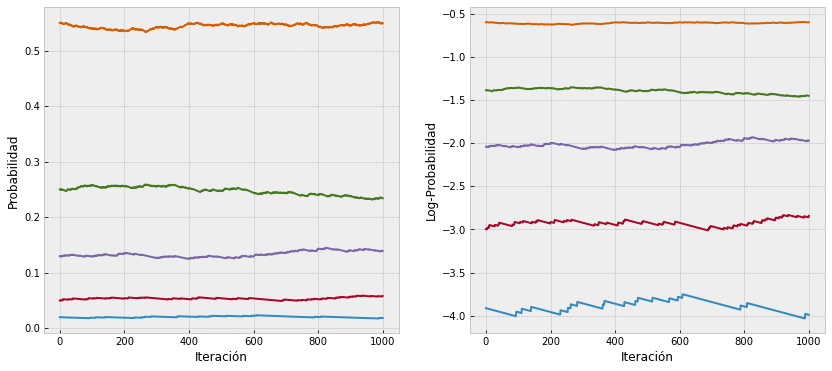

In [19]:
import matplotlib.pyplot as plt

probs_ori=np.asarray([0.02, 0.05, 0.13, 0.25, 0.55])
probs=np.asarray([0.02, 0.05, 0.13, 0.25, 0.55])

all_probs=np.asarray([probs])
for i in range(1000):
    choice=np.zeros(probs.shape)
    choice[np.random.choice(range(len(probs)), p=probs)]=1
    probs=probs*0.999+choice*0.001
    all_probs=np.concatenate((all_probs, probs.reshape(1, -1)))

fig, axes= plt.subplots(1,2, figsize=(14,6))
axes[0].plot(all_probs)
axes[1].plot(np.log(all_probs))

axes[0].set_xlabel("Iteración")
axes[1].set_xlabel("Iteración")
axes[0].set_ylabel("Probabilidad")
axes[1].set_ylabel("Log-Probabilidad")

plt.show()